# Chapter 9 Exercises

In [72]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

def save_fig(fig_id, tight_layout=True):
    path = os.path.join("images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

Implement Logistic Regression with Mini-batch Gradient Descent using TensorFlow. Train it and evaluate it on the moons dataset (introduced in Chapter 5). Try adding all the bells and whistles:

Define the graph within a logistic_regression() function that can be reused easily.

Save checkpoints using a Saver at regular intervals during training, and save the final model at the end of training.

Restore the last checkpoint upon startup if training was interrupted.

Define the graph using nice scopes so the graph looks good in TensorBoard.

Add summaries to visualize the learning curves in TensorBoard.

Try tweaking some hyperparameters such as the learning rate or the mini-batch size and look at the shape of the learning curve.

In [2]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=1000, noise=0.15, random_state=42)

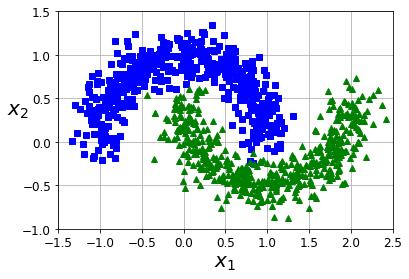

In [3]:
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In [4]:
import tensorflow as tf

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [13]:
X_bias = np.c_[np.ones((1000, 1)), X]

In [15]:
y_reshape = y.reshape(-1, 1)

In [17]:
test_ratio = 0.2
test_size = int(1000 * test_ratio)
X_train = X_bias[:-test_size]
X_test = X_bias[-test_size:]
y_train = y_reshape[:-test_size]
y_test = y_reshape[-test_size:]

In [18]:
def random_batch(X_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

In [21]:
n_inputs = 2

In [26]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n_inputs + 1, 1], -1.0, 1.0, seed=42), name="theta")
logits = tf.matmul(X, theta, name="logits")

In [27]:
y_proba = tf.sigmoid(logits)

In [28]:
loss = tf.losses.log_loss(y, y_proba)

In [64]:
learning_rate = 0.01
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

In [65]:
init = tf.global_variables_initializer()

In [66]:
n_epochs = 1000
batch_size = 50
n_batches = int(np.ceil(1000 / batch_size))

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val = loss.eval({X: X_test, y: y_test})
        if epoch % 100 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)

    y_proba_val = y_proba.eval(feed_dict={X: X_test, y: y_test})

Epoch: 0 	Loss: 0.795765
Epoch: 100 	Loss: 0.289518
Epoch: 200 	Loss: 0.291344
Epoch: 300 	Loss: 0.290947
Epoch: 400 	Loss: 0.288435
Epoch: 500 	Loss: 0.290583
Epoch: 600 	Loss: 0.289626
Epoch: 700 	Loss: 0.291202
Epoch: 800 	Loss: 0.291284
Epoch: 900 	Loss: 0.291575


In [67]:
y_pred = (y_proba_val >= 0.5)
y_pred[:5]

array([[ True],
       [ True],
       [False],
       [ True],
       [ True]], dtype=bool)

In [68]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_test, y_pred)

0.83177570093457942

In [69]:
recall_score(y_test, y_pred)

0.89898989898989901

In [63]:
X_train_enhanced = np.c_[X_train,
                         np.square(X_train[:, 1]),
                         np.square(X_train[:, 2]),
                         X_train[:, 1] ** 3,
                         X_train[:, 2] ** 3]
X_test_enhanced = np.c_[X_test,
                        np.square(X_test[:, 1]),
                        np.square(X_test[:, 2]),
                        X_test[:, 1] ** 3,
                        X_test[:, 2] ** 3]

In [73]:
reset_graph()

In [6]:
def logistic_regression(X, y, initializer=None, seed=42, learning_rate=0.01):
    n_inputs_including_bias = int(X.get_shape()[1])
    with tf.name_scope("logistic_regression"):
        with tf.name_scope("model"):
            if initializer is None:
                initializer = tf.random_uniform([n_inputs_including_bias, 1], -1.0, 1.0, seed=seed)
            theta = tf.Variable(initializer, name="theta")
            logits = tf.matmul(X, theta, name="logits")
            y_proba = tf.sigmoid(logits)
        with tf.name_scope("train"):
            loss = tf.losses.log_loss(y, y_proba, scope="loss")
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            training_op = optimizer.minimize(loss)
            loss_summary = tf.summary.scalar('log_loss', loss)
        with tf.name_scope("init"):
            init = tf.global_variables_initializer()
        with tf.name_scope("save"):
            saver = tf.train.Saver()
    return y_proba, loss, training_op, loss_summary, init, saver

In [7]:
from datetime import datetime

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

In [8]:
n_inputs = 2 + 4
logdir = log_dir("logreg")

X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(X, y)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [79]:
n_epochs = 10001
batch_size = 50
m = 1000
n_batches = int(np.ceil(m / batch_size))

checkpoint_path = "/tmp/my_logreg_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_logreg_model"

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)

    for epoch in range(start_epoch, n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
        file_writer.add_summary(summary_str, epoch)
        if epoch % 500 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))

    saver.save(sess, final_model_path)
    y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
    os.remove(checkpoint_epoch_path)

Epoch: 0 	Loss: 0.63265
Epoch: 500 	Loss: 0.180248
Epoch: 1000 	Loss: 0.142335
Epoch: 1500 	Loss: 0.122186
Epoch: 2000 	Loss: 0.109162
Epoch: 2500 	Loss: 0.100051
Epoch: 3000 	Loss: 0.0931826
Epoch: 3500 	Loss: 0.0879004
Epoch: 4000 	Loss: 0.0836217
Epoch: 4500 	Loss: 0.0801048
Epoch: 5000 	Loss: 0.0771941
Epoch: 5500 	Loss: 0.0746492
Epoch: 6000 	Loss: 0.0725756
Epoch: 6500 	Loss: 0.0708425
Epoch: 7000 	Loss: 0.0692579
Epoch: 7500 	Loss: 0.0678185
Epoch: 8000 	Loss: 0.066504
Epoch: 8500 	Loss: 0.06541
Epoch: 9000 	Loss: 0.0644171
Epoch: 9500 	Loss: 0.0634998
Epoch: 10000 	Loss: 0.0627122


In [81]:
y_pred = (y_proba_val >= 0.5)

In [82]:
precision_score(y_test, y_pred)

0.97979797979797978

In [83]:
recall_score(y_test, y_pred)

0.97979797979797978